# Poisson Models to Football Scores

The model is founded on the number of goals scored/conceded by each team. Teams that have been higher scorers in the past have a greater likelihood of scoring goals in the future. For example, we'll import all match results from the Premier League (2016/17) season

#### Reading dataset

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

epl_1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617 = epl_1617[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl_1617 = epl_1617.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1617.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1


We imported a csv as a pandas dataframe, which contains various information for each of the 380 EPL games in the 2016-17 English Premier League season. We restricted the dataframe to the columns in which we're interested (specifically, team names and numer of goals scored by each team).

Our task is to model the final round of fixtures in the season, so we must remove the last 10 rows (each gameweek consists of 10 matches).

In [26]:
epl_1617 = epl_1617[:-10]
epl_1617.mean()

HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

You'll notice that, on average, the home team scores more goals than the away team. This is the so called 'home (field) advantage.

## Poisson Distribution

Poisson Distribution is a discrete probability distribution that describes the probability of the number of events within a specific time period (e.g 90 mins) with a known average rate of occurrence. A key assumption is that the number of events is independent of time. In our context, this means that goals don't become more/less likely by the number of goals already scored in the match. Instead, the number of goals is expressed purely as function an average rate of goals.

Formally:
    
$$ P\left( x \right) = \frac{{e^{ - \lambda } \lambda ^x }}{{x!}} $$

where  $\lambda$ represents the average rate (e.g. average number of goals, average number of letters you receive, etc.)

So, we can treat the number of goals scored by the home and away team as two independent Poisson distributions. The plot below shows the proportion of goals scored compared to the number of goals estimated by the corresponding Poisson distributions.

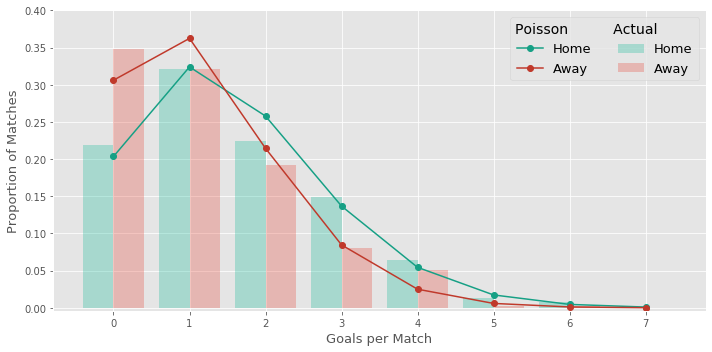

In [41]:
poisson_pred = np.column_stack([[poisson.pmf(i, epl_1617.mean()[j]) for i in range(8)] for j in range(2)])

plt.figure(figsize=(10,5))
plt.hist(epl_1617[['HomeGoals', 'AwayGoals']].values, range(9), 
         alpha=0.3, label=['Home', 'Away'],density=True, color=["#1abc9c", "#e74c3c"])
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#16a085')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson          Actual        ", prop = {'size':'14'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

We can use this statistical model to estimate the probability of specfic events.

$$ 
\begin{align} 
P(\geq 2|Home) = P(2|Home) + P(3|Home) + \ ... \ & = 0.258 \ + \ 0.137 + \ ... \ = 0.47
\end{align} 
$$

The probability of a draw is simply the sum of the events where the two teams score the same amount of goals.

$$
\begin{align}
P(Draw) = P(0|Home) \times P(0|Away) + P(1|Home) \times P(1|Away) + \ ... \ \\ 
        = (0.203 \times 0.306) + (0.324 \times 0.362) + \ ... \ = \ 0.248
\end{align}
$$

Note that we consider the number of goals scored by each team to be independent events (i.e. P(A n B) = P(A) P(B)). The difference of two Poisson distribution is actually called a **Skellam distribution**. So we can calculate the probability of a draw by inputting the mean goal values into this distribution

In [43]:
ht_mean = epl_1617.mean()[0]
at_mean = epl_1617.mean()[1]

# 
print('probability of draw between home and away team: %s' % (skellam.pmf(0, ht_mean, at_mean)))
print('probability of home team winning by one goal: %s' % (skellam.pmf(1, ht_mean, at_mean)))
print('probability of away team winning by one goal: %s' % (skellam.pmf(-1, ht_mean, at_mean)))

probability of draw between home and away team: 0.24809376810717076
probability of home team winning by one goal: 0.22706765807563964
probability of away team winning by one goal: 0.16885506661651978


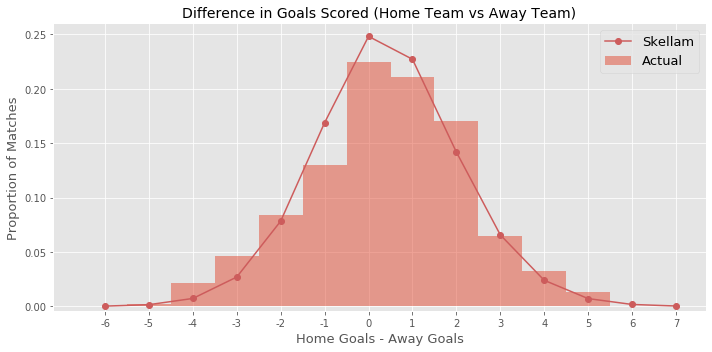

In [44]:
plt.figure(figsize=(10,5))
skellam_pred = [skellam.pmf(i,  epl_1617.mean()[0],  epl_1617.mean()[1]) for i in range(-6,8)]

plt.hist(epl_1617[['HomeGoals']].values - epl_1617[['AwayGoals']].values, range(-6,8), 
         alpha=0.5, label='Actual',density=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14)
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

So, hopefully you can see how we can adapt this approach to model specific matches. We just need to know the average number of goals scored by each team and feed this data into a Poisson model. Let's have a look at the distribution of goals scored by Chelsea and Sunderland (teams who finished 1st and last, respectively).

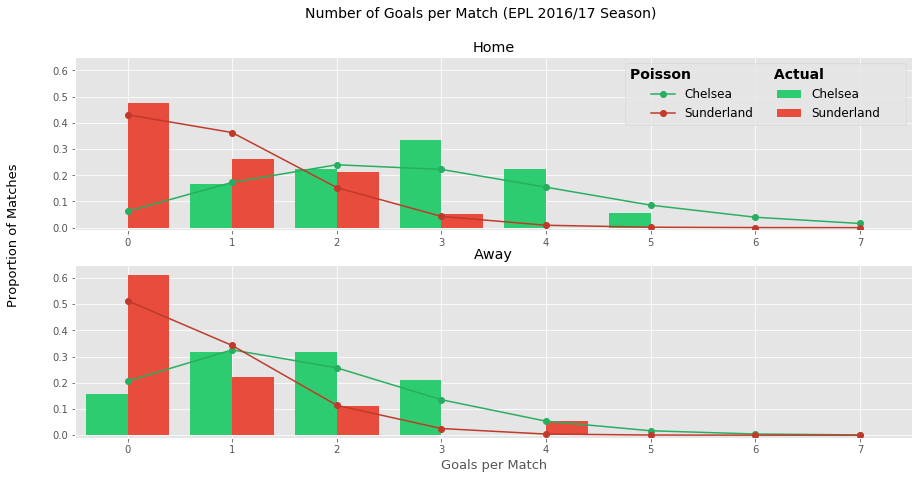

In [45]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(15,7))


chel_home = epl_1617[epl_1617['HomeTeam']=='Chelsea'][['HomeGoals']].apply(pd.value_counts,normalize=True)
chel_home_pois = [poisson.pmf(i,np.sum(np.multiply(chel_home.values.T,chel_home.index.T),axis=1)[0]) for i in range(8)]
sun_home = epl_1617[epl_1617['HomeTeam']=='Sunderland'][['HomeGoals']].apply(pd.value_counts,normalize=True)
sun_home_pois = [poisson.pmf(i,np.sum(np.multiply(sun_home.values.T,sun_home.index.T),axis=1)[0]) for i in range(8)]

chel_away = epl_1617[epl_1617['AwayTeam']=='Chelsea'][['AwayGoals']].apply(pd.value_counts,normalize=True)
chel_away_pois = [poisson.pmf(i,np.sum(np.multiply(chel_away.values.T,chel_away.index.T),axis=1)[0]) for i in range(8)]
sun_away = epl_1617[epl_1617['AwayTeam']=='Sunderland'][['AwayGoals']].apply(pd.value_counts,normalize=True)
sun_away_pois = [poisson.pmf(i,np.sum(np.multiply(sun_away.values.T,sun_away.index.T),axis=1)[0]) for i in range(8)]


chel_home_index = chel_home.index.values-0.2
chel_home_values = chel_home['HomeGoals'].values

sun_home_index = sun_home.index.values+0.2
sun_home_values = sun_home['HomeGoals'].values

chel_away_index = chel_away.index.values-0.2
chel_away_values = chel_away['AwayGoals'].values

sun_away_index = sun_away.index.values+0.2
sun_away_values = sun_away['AwayGoals'].values

ax1.bar(chel_home_index,chel_home_values,width=0.4,color="#2ecc71",label="Chelsea")
ax1.bar(sun_home_index,sun_home_values,width=0.4,color="#e74c3c",label="Sunderland")

ax1.set_title('Home')
ax2.set_title('Away')
pois1, = ax1.plot([i for i in range(8)], chel_home_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "#27ae60")
pois1, = ax1.plot([i for i in range(8)], sun_home_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "#c0392b")
leg=ax1.legend(loc='upper right', fontsize=12, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'14', 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])

ax2.bar(chel_away_index,chel_away_values,width=0.4,color="#2ecc71",label="Chelsea", align='center')
ax2.bar(sun_away_index, sun_away_values,width=0.4,color="#e74c3c",label="Sunderland", align='center')
pois1, = ax2.plot([i for i in range(8)], chel_away_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "#27ae60")
pois1, = ax2.plot([i for i in range(8)], sun_away_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "#c0392b")
ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])
fig.suptitle("Number of Goals per Match (EPL 2016/17 Season)",size=14)
ax2.set_xlabel("Goals per Match",size=13)
ax2.text(-1.15, 0.5, 'Proportion of Matches', rotation=90, size=13)

plt.show()

# Building a Model

You should now be convinced that the number of goals scored by each team can be approximated by a Poisson distribution. Due to a relatively sample size (each team plays at most 19 home/away games), the accuracy of this approximation can vary significantly (especially earlier in the season when teams have played fewer games). Similar to before, we could now calculate the probability of various events in this Chelsea Sunderland match. But rather than treat each match separately, we'll build a more general Poisson regression model

#### Transforming dataset

In [50]:
print(epl_1617)

           HomeTeam    AwayTeam  HomeGoals  AwayGoals
0           Burnley     Swansea          0          1
1    Crystal Palace   West Brom          0          1
2           Everton   Tottenham          1          1
3              Hull   Leicester          2          1
4          Man City  Sunderland          2          1
..              ...         ...        ...        ...
365         Chelsea     Watford          4          3
366         Arsenal  Sunderland          2          0
367        Man City   West Brom          3          1
368     Southampton  Man United          0          0
369       Leicester   Tottenham          1          6

[370 rows x 4 columns]


In [9]:

goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

display(goal_model_data)

,team,opponent,goals,home
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1
...,...,...,...,...
365,Watford,Chelsea,3,0
366,Sunderland,Arsenal,0,0
367,West Brom,Man City,1,0
368,Man United,Southampton,0,0


In [10]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Mon, 06 Jan 2020   Deviance:                       776.11
Time:                        08:19:48   Pearson chi2:                     659.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      

We are interested in the values presented in the **coef** column in the model summary table, which are analogous to the slopes in linear regression. Similar to logistic regression, we take the exponent of the parameter values. A positive value implies more goals ( $e^{x} \gt 1 \ \forall x \gt 0 $ ), while values closer to zero represent more neutral effects ($e^{0}=1$). Towards the bottom of the table you might notice that home has a coef of 0.2969. This captures the fact that home teams generally score more goals than the away team (specifically, $e^{0.2969}$=1.35 times more likely). But not all teams are created equal. Chelsea has an estimate of 0.0789, while the corresponding value for Sunderland is -0.9619 (sort of saying Chelsea (Sunderland) are better (much worse!) scorers than average). Finally, the **opponent** values penalize/reward teams based on the quality of the opposition. This reflects the defensive strength of each team (Chelsea: -0.3036; Sunderland: 0.3707). In other words, you're less likely to score against Chelsea. Hopefully, that all makes both statistical and intuitive sense.

Let's start making some predictions for the upcoming matches. We simply pass our teams into poisson_model and it'll return the expected average number of goals for your team (we need to run it twice- we calculate the expected average number of goals for each team separately). So let's see how many goals we expect Chelsea and Sunderland to score.

In [47]:
pred_chelsea_goals = poisson_model.predict(pd.DataFrame(data={'team': 'Chelsea', 'opponent': 'Sunderland',
                                       'home':1},index=[1]))

pred_sund_goals = poisson_model.predict(pd.DataFrame(data={'team': 'Sunderland', 'opponent': 'Chelsea',
                                       'home':0},index=[1]))

print('Chelsea: ', float(round(pred_chelsea_goals,3)), "| Sunderland:",  float(round(pred_sund_goals,3)))

Chelsea:  3.062 | Sunderland: 0.409


Just like before, we have two Poisson distributions. From this, we can calculate the probability of various events. I'll wrap this in a simulate_match function.

In [12]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=3)

array([[0.03108485, 0.01272529, 0.00260469, 0.00035543],
       [0.0951713 , 0.03896054, 0.00797469, 0.00108821],
       [0.14569118, 0.059642  , 0.01220791, 0.00166586],
       [0.14868571, 0.06086788, 0.01245883, 0.0017001 ]])

This matrix simply shows the probability of Chelsea (rows of the matrix) and Sunderland (matrix columns) scoring a specific number of goals. For example, along the diagonal, both teams score the same the number of goals (e.g. P(0-0)=0.031). So, you can calculate the odds of draw by summing all the diagonal entries. Everything below the diagonal represents a Chelsea victory (e.g P(3-0)=0.149), And you can estimate P(Over 2.5 goals) by summing all entries except the four values in the upper left corner. Luckily, we can use basic matrix manipulation functions to perform these calculations.

In [49]:
chel_sun = simulate_match(poisson_model, "Chelsea", "Sunderland", max_goals=10)

# chelsea win
pred_chelsea_win = np.sum(np.tril(chel_sun, -1))
pred_draw = np.sum(np.diag(chel_sun))
pred_sund_win = np.sum(np.triu(chel_sun, 1))

print('Chelsea:', pred_chelsea_win)
print('Draw:', pred_draw)
print('Sunderland:', pred_sund_win)

Chelsea: 0.8885986612364137
Draw: 0.0840934926864957
Sunderland: 0.026961819942852974


### Evaluate against bookmakers

In [14]:
epl_1617_halves = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617_halves = epl_1617_halves[['FTHG', 'FTAG', 'HTHG', 'HTAG']]
epl_1617_halves['FHgoals'] = epl_1617_halves['HTHG'] + epl_1617_halves['HTAG']
epl_1617_halves['SHgoals'] = epl_1617_halves['FTHG'] + epl_1617_halves['FTAG'] - epl_1617_halves['FHgoals']
epl_1617_halves = epl_1617_halves[['FHgoals', 'SHgoals']]
epl_1617_halves.mean()

FHgoals    1.215789
SHgoals    1.584211
dtype: float64

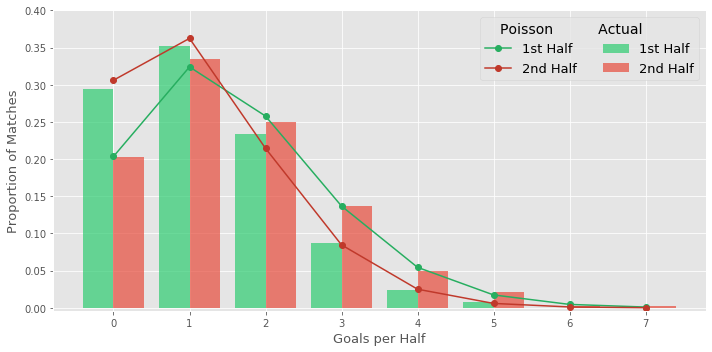

In [24]:
plt.figure(figsize=(10,5))

poisson_halves_pred = np.column_stack([[poisson.pmf(i, epl_1617_halves.mean()[j]) for i in range(8)] for j in range(2)])

plt.hist(epl_1617_halves.values, range(9), 
         alpha=0.7, label=['1st Half', '2nd Half'],density=True, color=["#2ecc71", "#e74c3c"])
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="1st Half", color = '#27ae60')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="2nd Half", color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson          Actual        ", prop = {'size':'14'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Half",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()